# Text preprocessing

220831, wygo

- 1) Crawling&Gathering paper/report/blog/SNS/AIhub etc... on HTML/PDF format
- 2) Parsing HTML/PDF to txt
- 3) Cleansing noisy text
- 4) Normalizing noisy text
- 5) Making bert format

In [1]:
!pip install tika
import nltk
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for tika: filename=tika-1.24-py3-none-any.whl size=32893 sha256=aeb8f4d38df064faecb4393c3d29404781ca7b72139c967ae0c219eed4eb8816
  Stored in directory: /root/.cache/pip/wheels/ec/2b/38/58ff05467a742e32f67f5d0de048fa046e764e2fbb25ac93f3
Successfully built tika


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
# download data
!git clone https://github.com/airobotlab/lecture_hyperparameter_tuning.git
!mv lecture_hyperparameter_tuning/data ./
!rm -rf lecture_hyperparameter_tuning

Cloning into 'lecture_hyperparameter_tuning'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 72 (delta 3), reused 0 (delta 0), pack-reused 64
Unpacking objects: 100% (72/72), done.


## 1) Crawling&Gathering paper/report/blog/SNS/AIhub etc... on HTML/PDF format

In [3]:
## import
import nltk
from nltk import tokenize
from nltk.tokenize import sent_tokenize
from bs4 import BeautifulSoup
import os
import re
import glob
import matplotlib.pyplot as plt

from itertools import chain
from tika import parser as pdf_parser
import pprint
import json
import time
import argparse
import copy
from tqdm import tqdm
import shutil

def enter_space_normalizer(text):
    text = re.sub("\n\n+",  "\n\n", text,  0,  re.I | re.S)
    text = re.sub(" +",   " ", text,  0,  re.I | re.S)
    return text.strip()

print_json = pprint.PrettyPrinter(indent=4).pprint

In [4]:
## 실행
verbose = True
output_txt_path='filtered_text.txt'
file_format = '*.html'
# file_format = '/*.pdf'
json_format = '*.json'
html_src = 'data'

# for idx, input_path in tqdm(enumerate(os.listdir(html_src)[:1])):
for idx, input_path in tqdm(enumerate(os.listdir(html_src))):    
#     print(idx, input_path)

    input_path = os.path.join(html_src, input_path)
    output_txt_path='filtered_text.txt'

    ###########################################################
    # 입력 파일 체크, 저장path 설정
    if not os.path.exists(input_path):
        print('Folder not exist! : %s'%(input_path))
        assert 'Folder not exists! : %s'%(input_path)
    output_txt_path = os.path.join(input_path, output_txt_path)
    
    ###########################################################
    ## 0) inspection
    # 0.1) html or pdf check
    # 폴더 안의 html 파일만 검색
    file_path = glob.glob(os.path.join(input_path, file_format))
    # html이 안들어 있는 경우 패스
    if len(file_path) == 0:
        print('no have file! - %s' % (os.path.join(input_path, file_format)))
    else:
        file_path = file_path[0]  # list 에서 html만 선택
    file_name = file_path.split('/')[-1].split('.')[0]  # folder의 html의 이름
    input_file_path = file_path
   
    ###########################################################
    ## 1) file check
    # 1.1) pdf file check
    if verbose:
        print('####  크롤링 시작  %s'%('#'*50))
        print('## input_path : %s'%(input_path))
        print('## input_html : %s'%(input_file_path))
        print('## output_txt : %s'%(output_txt_path))
    
    # 파일이 없으면 멈추자
    if not os.path.exists(input_file_path):
        print('1.1) File not exist! : %s'%(input_file_path))
        assert '1.1) File not exists! : %s'%(input_file_path)

    ###########################################################
    ## 2) parsing pdf or html to txt
    result = {}  # 모든 결과 저장
    try:
        if 'pdf' in file_format:
            print('format: PDF')
            xml = pdf_parser.from_file(input_file_path, xmlContent=True)
            list_page = xml['content'].split('<div class="page">')

            string = ''
            for page in list_page:
                string += page
            string = string.strip()
            result['raw_data'] = string

        elif 'html' in file_format:
#             print('format: HTML')
            with open(input_file_path, 'r', encoding='utf-8') as f:
                html = f.read()
                soup = BeautifulSoup(html, 'html.parser')
                string = soup.text.strip()
                result['raw_data'] = string
        else:
            assert 'Not pdf or html'

    except Exception as error:
        print('2) load error', error)
    
    ###########################################################
    ## 3) cutting
    # 3.1) 본문 뒷쪽 자르기
    string = string.replace(u'\ue802', r' ').replace(u'\ue804', r' ')  # 이상한 특수문자 제거
    pattern_end = 'Found this article interesting?'
    string_end = string.split(pattern_end)[0].strip()
    result['string_end'] = string_end
    
    # 3.2) 제목과 앞쪽 자르기
    pattern_start = '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'
    title = string_end.split(pattern_start)[0].strip()
    start_string_end = string_end.split(pattern_start)[1].strip()
    result['title'] = title
    result['start_string_end'] = start_string_end
#     print('Title : %s'%title)    
    
    # 3.3) 첫줄인 날짜를 없앤 후 문단 단위로 쪼갬 
    pattern_content = '\n'       
    content = start_string_end.split(pattern_content)[1:] # 제목, 날짜 날림
    content = '\n'.join(content)
    content_split = content.split(pattern_content)  # 문단 단위로 쪼갬    
    result['content_split'] = content_split
    
    # 3.4) AI입력형태로 변환, 1line 1 sentence, 문단 간 빈줄 하나
    sentence_normalized = [sent_tokenize(sentences) for sentences in content_split]
    # 1 line 1 sentence, 문단이 다르면 빈줄 하나 추가
    tmp = []
    for list_sentence in sentence_normalized:
        tmp.append('\n'.join(list_sentence))
    tmp_string = '\n\n'.join(tmp)
    final_string = enter_space_normalizer(tmp_string)
    
    # 3.5) 제목이 있으면 맨 위에 제목, 다음 빈줄
    if len(title) > 5:
        final_string = title + '\n\n' + final_string
    
    result['final_string'] = final_string

    ###########################################################
    ## 5) check
    if len(final_string) < 20:
        print('텍스트 크롤링 실패: %s\n%s'%(folder_name, final_string))

    if verbose:
        print('####  크롤링 완료  %s'%('#'*50))
        print(result['final_string'])

4it [00:00, 48.33it/s]

####  크롤링 시작  ##################################################
## input_path : data/4
## input_html : data/4/Java_Zero_day_vulnerability_exploited_in_the_Wild.html
## output_txt : data/4/filtered_text.txt
####  크롤링 완료  ##################################################
Java Zero-day vulnerability exploited in the Wild

Really a bad weekend for Internet users.
Three previously unknown critical zero-day vulnerabilities were revealed in Adobe's Flash Player over the weekend, thanks to Hacking team data Breach in which 400GB of internal data were leaked over the Internet.

Now, a new zero-day vulnerability has been reported in Oracle's Java that is reportedly being exploited in the wild by hackers to target government armed forces.

Cybercriminals are actively exploiting the Java-based zero-day flaw in an attempt to target U.S. defense agencies and members of NATO, Trend Micro security researchers warned in a blog post published Sunday.

 var adpushup = adpushup || {}; adpushup.que = adp

In [5]:
## 함수화
def parsing_html(input_path, output_txt_path='filtered_text.txt', file_format = '*.html', verbose=False):
    ###########################################################
    # 입력 파일 체크, 저장path 설정
    if not os.path.exists(input_path):
        print('Folder not exist! : %s'%(input_path))
        assert 'Folder not exists! : %s'%(input_path)
    output_txt_path = os.path.join(input_path, output_txt_path)
    
    ###########################################################
    ## 0) inspection
    # 0.1) html or pdf check
    # 폴더 안의 html 파일만 검색
    file_path = glob.glob(os.path.join(input_path, file_format))
    # html이 안들어 있는 경우 패스
    if len(file_path) == 0:
        print('no have file! - %s' % (os.path.join(input_path, file_format)))
    else:
        file_path = file_path[0]  # list 에서 html만 선택
    file_name = file_path.split('/')[-1].split('.')[0]  # folder의 html의 이름
    input_file_path = file_path
   
    ###########################################################
    ## 1) file check
    # 1.1) pdf file check
    if verbose:
        print('####  크롤링 시작  %s'%('#'*50))
        print('## input_path : %s'%(input_path))
        print('## input_html : %s'%(input_file_path))
        print('## output_txt : %s'%(output_txt_path))
    
    # 파일이 없으면 멈추자
    if not os.path.exists(input_file_path):
        print('1.1) File not exist! : %s'%(input_file_path))
        assert '1.1) File not exists! : %s'%(input_file_path)

    ###########################################################
    ## 2) parsing pdf or html to txt
    result = {}  # 모든 결과 저장
    try:
        if 'pdf' in file_format:
            print('format: PDF')
            xml = pdf_parser.from_file(input_file_path, xmlContent=True)
            list_page = xml['content'].split('<div class="page">')

            string = ''
            for page in list_page:
                string += page
            string = string.strip()
            result['raw_data'] = string

        elif 'html' in file_format:
#             print('format: HTML')
            with open(input_file_path, 'r', encoding='utf-8') as f:
                html = f.read()
                soup = BeautifulSoup(html, 'html.parser')
                string = soup.text.strip()
                result['raw_data'] = string
        else:
            assert 'Not pdf or html'

    except Exception as error:
        print('2) load error', error)
    
    ###########################################################
    ## 3) cutting
    # 3.1) 본문 뒷쪽 자르기
    string = string.replace(u'\ue802', r' ').replace(u'\ue804', r' ')  # 이상한 특수문자 제거
    pattern_end = 'Found this article interesting?'
    string_end = string.split(pattern_end)[0].strip()
    result['string_end'] = string_end
    
    # 3.2) 제목과 앞쪽 자르기
    pattern_start = '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n'
    title = string_end.split(pattern_start)[0].strip()
    start_string_end = string_end.split(pattern_start)[1].strip()
    result['title'] = title
    result['start_string_end'] = start_string_end
#     print('Title : %s'%title)    
    
    # 3.3) 첫줄인 날짜를 없앤 후 문단 단위로 쪼갬 
    pattern_content = '\n'       
    content = start_string_end.split(pattern_content)[1:] # 제목, 날짜 날림
    content = '\n'.join(content)
    content_split = content.split(pattern_content)  # 문단 단위로 쪼갬    
    result['content_split'] = content_split
    
    # 3.4) AI입력형태로 변환, 1line 1 sentence, 문단 간 빈줄 하나
    sentence_normalized = [sent_tokenize(sentences) for sentences in content_split]
    # 1 line 1 sentence, 문단이 다르면 빈줄 하나 추가
    tmp = []
    for list_sentence in sentence_normalized:
        tmp.append('\n'.join(list_sentence))
    tmp_string = '\n\n'.join(tmp)
    final_string = enter_space_normalizer(tmp_string)
    
    # 3.5) 제목이 있으면 맨 위에 제목, 다음 빈줄
    if len(title) > 5:
        final_string = title + '\n\n' + final_string
    
    result['final_string'] = final_string

    ###########################################################
    ## 5) check
    if len(final_string) < 20:
        print('텍스트 크롤링 실패: %s\n%s'%(folder_name, final_string))

    if verbose:
        print('####  크롤링 완료  %s'%('#'*50))
        print(result['final_string'])
        
    return result

In [6]:
result  = parsing_html(input_path='./data/1')

### check

In [7]:
print(result['raw_data'][:500])

What does the Poetry with Citadel trojan ?















February 23, 2013Anonymous
Recently we published an article on the attacks against Japanese banks using a new variant of the popular Zeus, one of the most prolific malware of recent history, security experts in fact have detected various versions of the popular malicious code that hit also mobile and social networking platforms.
Due its flexibility the malware has been re-engineered several times by cyber criminals that adapted its stru


In [8]:
print(result['final_string'][:500])

What does the Poetry with Citadel trojan ?

Recently we published an article on the attacks against Japanese banks using a new variant of the popular Zeus, one of the most prolific malware of recent history, security experts in fact have detected various versions of the popular malicious code that hit also mobile and social networking platforms.

Due its flexibility the malware has been re-engineered several times by cyber criminals that adapted its structure to specific purposes and context, le


## 3) Cleansing noisy text & 4) Normalizing noisy text
## Unicode 삭제

In [9]:
# unicode 딕셔너리 다운
import json

if not os.path.isfile('./data/unicode_dict.json'):
    URL_unicode = 'https://jehyunlee.github.io/2022/08/27/Python-DS-111-textprocfn/unicode_dict.zip'    
    
    !wget https://jehyunlee.github.io/2022/08/27/Python-DS-111-textprocfn/unicode_dict.zip
    !mv unicode_dict.zip ./data/
    !unzip ./data/unicode_dict.zip
    !mv unicode_dict.json ./data/
    os.remove('./data/unicode_dict.zip')

with open("./data/unicode_dict.json", encoding='utf-8') as f:
    dict_unicode = json.load(f)

# unicode filtering
def get_ufiltered(text):
    text_ufiltered = ""
    for i, c in enumerate(text):
        if dict_unicode.get(c):
            ufiltered = dict_unicode[c]
        else:
            ufiltered = c
        text_ufiltered = text_ufiltered + ufiltered
    return text_ufiltered

# 함수 실행
result['unicode_filtered'] = get_ufiltered(result['final_string'])
print(result['unicode_filtered'][:500])

--2022-08-31 05:08:39--  https://jehyunlee.github.io/2022/08/27/Python-DS-111-textprocfn/unicode_dict.zip
Resolving jehyunlee.github.io (jehyunlee.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to jehyunlee.github.io (jehyunlee.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1070 (1.0K) [application/zip]
Saving to: ‘unicode_dict.zip’

unicode_dict.zip    100%[===================>]   1.04K  --.-KB/s    in 0s      

2022-08-31 05:08:39 (34.3 MB/s) - ‘unicode_dict.zip’ saved [1070/1070]

Archive:  ./data/unicode_dict.zip
  inflating: unicode_dict.json       
What does the Poetry with Citadel trojan ?

Recently we published an article on the attacks against Japanese banks using a new variant of the popular Zeus, one of the most prolific malware of recent history, security experts in fact have detected various versions of the popular malicious code that hit also mobile and social networking platforms.

Due

## 5) Making bert format

In [10]:
## config
html_src = 'data'

html_bert_out= html_src + '_bert'
output_txt_path = 'filtered_text.txt'

file_format = '*.html'
# file_format = '/*.pdf'

start_symbol_and_solr_id = '<<doc>>_data_'

max_tokens = 50
min_tokens = 1
min_characters = 2  # 2 이상만 담자, '.', ':' 이런것들은 제끼자

# 특수문자 제거 : ['‑', '€', 'медии', 'カジ旅', '—', 'чуждите', '²', 'كازينو', 'ñ', '\xad', 'ä', '|', '\ufeff', '—\u2009', '–', '®', '£', 'ü', '‐', 'è', 'в', 'БГ', '•', '…', 'А', 'é', '™', 'ï']
remove_pattern = '[^0-9a-zA-Z ,.\"\'()`~!@#$%^&*()-_=+\[\]:;{}<>?/\n\t]+'  # 이상한 문자들 제거 패턴
black_list_pattern = []
remove_words = ['\xa0', '\xad']
stopword_list = []
# stopword_list = ['.setvalue(']  # txt 파일 저장 에러내는 string 제거
# stopword_list = ['APT40 relies heavily on web shells for an initial foothold into an organization.'.lower(),
#                  'Depending on placement, a web shell can provide continued access to victims\' environments, re-infect victim systems, and facilitate lateral movement.'.lower(),
#                 'Web shells are heavily relied on for nearly all stages of the attack lifecycle.'.lower(),
#                 'APT40 uses many methods for lateral movement throughout an environment, including custom scripts, web shells, a variety of tunnelers, as well as Remote Desktop Protocol (RDP).'.lower(),
#                 'APT40 primarily uses backdoors, including web shells, to maintain presence within a victim environment.'.lower(),
#                 'APT40 strongly favors web shells for maintaining presence, especially publicly available tools.'.lower()] # ['.setvalue(']

if os.path.isdir(html_bert_out):  
    shutil.rmtree(html_bert_out)
else:
    os.mkdir(html_bert_out)

In [11]:
## root 폴더 내 전체에 대한 일괄 파싱
data_root = 'data'

file_list = os.listdir(data_root)
all_txt = []

for folder_path in tqdm(file_list):
    input_folder_path = os.path.join(data_root, folder_path)
    if not os.path.isdir(input_folder_path):
        continue
    result = parsing_html(input_path=input_folder_path)
    all_txt.append(result['final_string'])

100%|██████████| 5/5 [00:00<00:00, 96.73it/s]


In [12]:
## 특수문자 체크, 이거에 안들어가면 재끼자
all_special_string = []
for document in all_txt:
    special_string = re.findall(remove_pattern, document)
    all_special_string.extend(special_string)

remove_special_token = list(set(all_special_string))
print(remove_special_token)

['||']


In [13]:
## bert 입력 만들기
for idx, document in enumerate(all_txt):
    with open(os.path.join(html_bert_out, 'bert.txt'), 'a', encoding='utf-8') as f_bert:
        bert_txt  = start_symbol_and_solr_id  + str(idx) + '\n'
        bert_txt += document  + '\n\n\n'
        f_bert.write(bert_txt)

done!! - 4개 문서, 65개 문장, 평균 26 단어/문장, 최대/최소 : 66 / 3


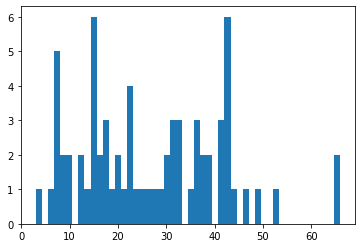

In [14]:
# 문장 통계
# 모든 txt의 문장만 list로 집합시키자
document_cnt, total_nmt_sentences = 0, []
for document_string in all_txt:
    document_cnt += 1
    for document_sentence in document_string.split('\n'):
        if document_sentence !='': 
            total_nmt_sentences.append(document_sentence)
            
num_word_of_sentence_list = [len(tmp.split()) for tmp in total_nmt_sentences]
print('done!! - %d개 문서, %d개 문장, 평균 %d 단어/문장, 최대/최소 : %d / %d' % (document_cnt, len(num_word_of_sentence_list)-document_cnt, (sum(num_word_of_sentence_list)/len(num_word_of_sentence_list)), max(num_word_of_sentence_list), min(num_word_of_sentence_list)))
plt.hist(num_word_of_sentence_list, bins=max_tokens);
beep = lambda x: os.system("echo -n '\a';sleep 0.3;" * x);beep(3);